In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

# 打印 Python 版本信息
print(sys.version_info)

# 遍历打印常用库的名称和版本号
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

# 检查是否有可用的 GPU (CUDA)，否则使用 CPU
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

sys.version_info(major=3, minor=14, micro=2, releaselevel='final', serial=0)
matplotlib 3.10.8
numpy 2.4.1
pandas 3.0.0
sklearn 1.8.0
torch 2.10.0+cu130
cuda:0


In [2]:
from sklearn.datasets import fetch_california_housing

# 加载数据集，并将下载的数据存储在 'data' 文件夹中
housing = fetch_california_housing(data_home='data')

# 打印数据集的详细描述信息
print(housing.DESCR)

# 打印特征数据的形状 (行数, 列数)
print(housing.data.shape)

# 打印目标值（房价）的形状
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [3]:
from sklearn.model_selection import train_test_split

# 1. 第一次拆分：把所有数据分为 "训练集+验证集" 和 "测试集"
# random_state 是随机种子，设置具体的数字是为了保证每次运行代码时，拆分的结果都是一样的
x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)

# 2. 第二次拆分：把 "训练集+验证集" 再次拆分为 "训练集" 和 "验证集"
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)

# 3. 打印各个数据集的形状 (行数, 列数)，检查拆分是否成功
# 训练集
print(x_train.shape, y_train.shape)
# 验证集
print(x_valid.shape, y_valid.shape)
# 测试集
print(x_test.shape, y_test.shape)

# 4. 把3个数据集都放到字典中，方便后续调用
dataset_maps = {
    "train": [x_train, y_train],
    "valid": [x_valid, y_valid],
    "test": [x_test, y_test],
}

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
from sklearn.preprocessing import StandardScaler

# 初始化标准化器
scaler = StandardScaler()

# 在训练集上进行 "fit" 操作
# fit 的作用是计算训练数据的 均值(mean) 和 方差(std)
scaler.fit(x_train)

,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True


In [5]:
from torch.utils.data import Dataset

class HousingDataset(Dataset):
    def __init__(self, mode='train'):
        # 1. 从之前定义的 dataset_maps 字典中获取对应的数据
        self.x, self.y = dataset_maps[mode]

        # 2. 数据标准化 + 转换为 PyTorch Tensor + 转为 float32 类型
        # 注意：这里直接调用了 scaler.transform 进行归一化
        self.x = torch.from_numpy(scaler.transform(self.x)).float()

        # 3. 处理标签：转 Tensor + 转 float32 + 重塑形状
        # reshape(-1, 1) 非常重要，它把一维数组变成二维的 "列向量" (N行, 1列)
        self.y = torch.from_numpy(self.y).float().reshape(-1, 1)

    def __len__(self):
        # 返回数据集的总长度
        return len(self.x)

    def __getitem__(self, idx):
        # 根据索引 idx 返回一条样本（特征 x 和 标签 y）
        return self.x[idx], self.y[idx]

# 实例化三个数据集对象
train_ds = HousingDataset("train")
valid_ds = HousingDataset("valid")
test_ds = HousingDataset("test")

# 检查一下类型，确认创建成功
print(type(train_ds))

<class '__main__.HousingDataset'>


In [6]:
from torch.utils.data import DataLoader

# 放到 DataLoader 中的 train_ds, valid_ds, test_ds 都是之前定义的 Dataset 类型数据
batch_size = 32

# 训练集加载器：通常需要打乱顺序 (shuffle=True)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# 验证集和测试集加载器：通常不需要打乱顺序 (shuffle=False)
val_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [7]:
# 定义模型类
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim=8):
        super().__init__()
        # 定义层结构：输入8 -> 隐藏30 -> ReLU -> 输出1
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 30),  # 线性层 1
            nn.ReLU(),                 # 激活函数
            nn.Linear(30, 1)           # 线性层 2 (输出层)
        )

    def forward(self, x):
        # x.shape [batch_size, 8]
        logits = self.linear_relu_stack(x)
        # logits.shape [batch_size, 1]
        return logits

# 实例化模型，并移动到 GPU (如果可用)
model = NeuralNetwork().to(device)

# 打印模型结构查看
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=1, bias=True)
  )
)


In [8]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """
        Args:
            patience (int, optional): 即使没有提升，也会继续等待的轮数 (Epochs)。默认是 5。
            min_delta (float, optional): 被判定为"有提升"的最小变化阈值。如果提升小于这个值，不算改进。默认是 0.01。
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1  # 初始化最佳分数为 -1
        self.counter = 0       # 计数器，记录连续多少次没有提升

    def __call__(self, metric):
        # 逻辑：判断当前的指标 (metric) 是否比 历史最佳 (best_metric + min_delta) 还要好
        if metric >= self.best_metric + self.min_delta:
            # Update best metric (如果有提升，更新最佳分数)
            self.best_metric = metric
            # Reset counter (重置计数器)
            self.counter = 0
        else:
            # 如果没有明显提升，计数器 +1
            self.counter += 1

    @property
    def early_stop(self):
        # 如果计数器超过了耐心值，返回 True，表示该停止了
        return self.counter >= self.patience

In [9]:
from sklearn.metrics import accuracy_score
# 注意：虽然原图中导入了 accuracy_score，但在回归任务中我们主要看 Loss，这里暂时没用到它

@torch.no_grad()  # 关键点 1：不计算梯度
def evaluating(model, dataloader, loss_fct):
    loss_list = []

    # 遍历验证集/测试集的数据
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)

        # 前向计算 (预测)
        logits = model(datas)

        # 计算损失 (验证集损失)
        loss = loss_fct(logits, labels)

        # .item() 取出单数值，存入列表
        loss_list.append(loss.item())

    # 返回平均损失
    return np.mean(loss_list)

In [14]:
def training(model, train_loader, val_loader, epoch, loss_fct, optimizer, early_stop_callback=None, eval_step=500):
    # 初始化记录字典，用来存 loss 曲线数据
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0
    model.train() # 开启训练模式 (启用 Dropout/BatchNorm 等)

    with tqdm(total=epoch * len(train_loader), mininterval=1.0) as pbar:

        for epoch_id in range(epoch):
            # 遍历训练集
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)

                # 1. 梯度清零 (非常重要，否则梯度会累加)
                optimizer.zero_grad()

                # 2. 模型前向计算 (Forward)
                logits = model(datas)

                # 3. 计算损失 (Loss)
                loss = loss_fct(logits, labels)

                # 4. 梯度回传 (Backward) - 计算每个参数的梯度
                loss.backward()

                # 5. 更新参数 (Update) - 优化器根据梯度调整参数
                optimizer.step()

                # 记录训练 loss (转为 float)
                loss_val = loss.cpu().item()
                record_dict["train"].append({
                    "loss": loss_val, "step": global_step
                })

                # --- 验证环节 ---
                if global_step % eval_step == 0:
                    model.eval() # 切换到评估模式
                    val_loss = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "step": global_step
                    })
                    model.train() # 切回训练模式

                    # --- 早停判定 (关键点) ---
                    if early_stop_callback is not None:
                        # 注意这里传入了 -val_loss (负的验证损失)
                        # 因为 loss 越小越好，取负号后就变成了 "越大越好"，符合 callback 的逻辑
                        early_stop_callback(-val_loss)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # 更新步数和进度条
                global_step += 1
                pbar.update(1)
                if global_step % 50 == 0:  # 每50步更新一次文字显示
                    pbar.set_postfix({"epoch": epoch_id})

    return record_dict

In [15]:
# 1. 设置超参数
epoch = 100 # 最大训练轮数

# 2. 初始化模型
model = NeuralNetwork()

# 3. 定义损失函数 (MSE - 均方误差，回归任务标准配置)
loss_fct = nn.MSELoss()

# 4. 定义优化器 (SGD - 随机梯度下降)
# lr=0.001 是学习率，momentum=0.9 是动量（加速收敛）
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 5. 定义早停机制
# patience=10: 容忍10次验证没有提升
# min_delta=1e-3: 提升小于 0.001 就不算数
early_stop_callback = EarlyStopCallback(patience=10, min_delta=1e-3)

# 6. 将模型移动到 GPU/CPU
model = model.to(device)

# 7. 开始训练！
record = training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_loader) # 每个 epoch 结束后验证一次
)

  0%|          | 0/72600 [00:00<?, ?it/s]

Early stop at epoch 64 / global_step 46464


这里之前报错是因为打印太快

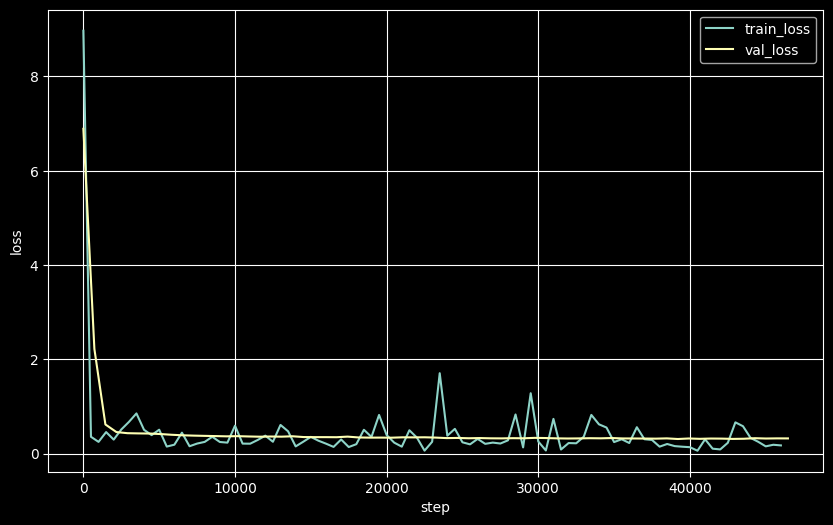

In [16]:
def plot_learning_curves(record_dict, sample_step=500):
    # 1. 构建 DataFrame 并设置索引
    # iloc[::sample_step] 的作用是每隔 sample_step (默认500) 取一行数据
    # 这样做的目的是为了让训练集的点变得稀疏一些，跟验证集的密度匹配，画图更清晰
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # 2. 绘图
    # 遍历所有列（这里主要是 'loss'）
    for idx, item in enumerate(train_df.columns):
        plt.figure(figsize=(10, 6)) # 我额外加了这行，让图大一点更清晰
        plt.plot(train_df.index, train_df[item], label=f"train_{item}")
        plt.plot(val_df.index, val_df[item], label=f"val_{item}")

        plt.grid()  # 显示网格
        plt.legend() # 显示图例
        plt.xlabel("step") # X轴标签
        plt.ylabel(item)   # Y轴标签

        plt.show()

# 调用函数绘图
plot_learning_curves(record)